### Download data from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
# Upload kaggle.json file for kaggle API key
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:49<00:00, 23.7MB/s]
100% 2.29G/2.29G [01:49<00:00, 22.4MB/s]


In [ ]:
!kaggle datasets download tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
100% 663M/663M [00:31<00:00, 24.3MB/s]
100% 663M/663M [00:31<00:00, 22.4MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip
!unzip tuberculosis-tb-chest-xray-dataset.zip

### Data Preparation

In [ ]:
import os

# Define the data path
pneumonia_data = '/content/chest_xray/train/PNEUMONIA'
tbc_data = '/content/TB_Chest_Radiography_Database/Tuberculosis'
normal_data = '/content/TB_Chest_Radiography_Database/Normal'

# Load the data path and define the label for each
def load_data(data_dir, label):
  image_paths = []
  labels = []

  for image in os.listdir(data_dir):
    image_paths.append(os.path.join(data_dir, image))
    labels.append(label)

  return image_paths, labels

p_image_path, p_label = load_data(pneumonia_data, "pneumonia")
t_image_path, t_label = load_data(tbc_data, "tbc")
n_image_path, n_label = load_data(normal_data, "normal")

image_paths = p_image_path + t_image_path + n_image_path
labels = p_label + t_label + n_label


In [ ]:
import pandas as pd

# Create a DataFrame and save the metadata of the image into a dataframe
data = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

In [ ]:
data.label.value_counts()

,count
label,
pneumonia,3875
normal,3500
tbc,700


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=data['label'].unique(),
    y=data['label']
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.6946236559139785, 1: 3.8452380952380953, 2: 0.7690476190476191}


In [ ]:
from torchvision import transforms
from PIL import Image
import os

# Define paths
tbc_dir = tbc_data
save_dir = "/content/aug_tbc"
os.makedirs(save_dir, exist_ok=True)

# Define augmentation transformations
augmentations = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])


# Apply augmentations and save new images
tbc_images = os.listdir(tbc_dir)
for idx, image_file in enumerate(tbc_images):
    img_path = os.path.join(tbc_dir, image_file)
    img = Image.open(img_path).convert("RGB")

    for j in range(4):  # Create 4 augmented images per TBC image
        augmented_img = augmentations(img)
        augmented_img = transforms.ToPILImage()(augmented_img)
        augmented_img.save(os.path.join(save_dir, f"tbc_aug_{idx}_{j}.png"))

print("Augmentation completed!")


Augmentation completed!


In [ ]:
aug_tbc_data, aug_tbc_label = load_data(save_dir, "tbc")

# add into the dataframe
aug_data = pd.DataFrame({
    'image_path': aug_tbc_data,
    'label': aug_tbc_label
})

# combine with others
data = pd.concat([data, aug_data], ignore_index=True)
data.label.value_counts()

,count
label,
pneumonia,3875
tbc,3500
normal,3500


In [ ]:
# Split data
from sklearn.model_selection import train_test_split

# split data
train_images, val_set = train_test_split(data, test_size=0.3, random_state=42)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(8700, 2)
(3263, 2)
(2175, 2)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# IMAGE_SIZE = 244
IMAGE_SIZE = 224  # for mobileNetV2
BATCH_SIZE = 32

image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="image_path",y_col="label",
                                      target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=BATCH_SIZE,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_set,x_col="image_path", y_col="label",
                                     target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=BATCH_SIZE,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="image_path", y_col="label",
                                    target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=BATCH_SIZE,
                                    shuffle=False
                                   )


Found 8700 validated image filenames belonging to 3 classes.
Found 2175 validated image filenames belonging to 3 classes.
Found 3263 validated image filenames belonging to 3 classes.


### CNN

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,610,499 (59.55 MB)

 Trainable params: 15,604,099 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint(filepath=f"checkpoint-combined_model.keras", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = [early_stopping, checkpoint, reduce_lr]

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
      train,
      epochs=100,
      validation_data=val,
      class_weight=class_weights_dict,
      callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7916 - loss: 1.8514
Epoch 1: val_loss improved from inf to 0.26179, saving model to checkpoint-combined_model.keras
272/272 ━━━━━━━━━━━━━━━━━━━━ 157s 462ms/step - accuracy: 0.7918 - loss: 1.8487 - val_accuracy: 0.9427 - val_loss: 0.2618 - learning_rate: 0.0010
Epoch 2/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9201 - loss: 0.3797
Epoch 2: val_loss did not improve from 0.26179
272/272 ━━━━━━━━━━━━━━━━━━━━ 91s 330ms/step - accuracy: 0.9200 - loss: 0.3804 - val_accuracy: 0.5636 - val_loss: 47.2544 - learning_rate: 0.0010
Epoch 3/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9270 - loss: 0.2314
Epoch 3: val_loss improved from 0.26179 to 0.16716, saving model to checkpoint-combined_model.keras
272/272 ━━━━━━━━━━━━━━━━━━━━ 92s 335ms/step - accuracy: 0.9270 - loss: 0.2314 - val_accuracy: 0.9507 - val_loss: 0.1672 - learning_rate: 0.0010
Epoch 4/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

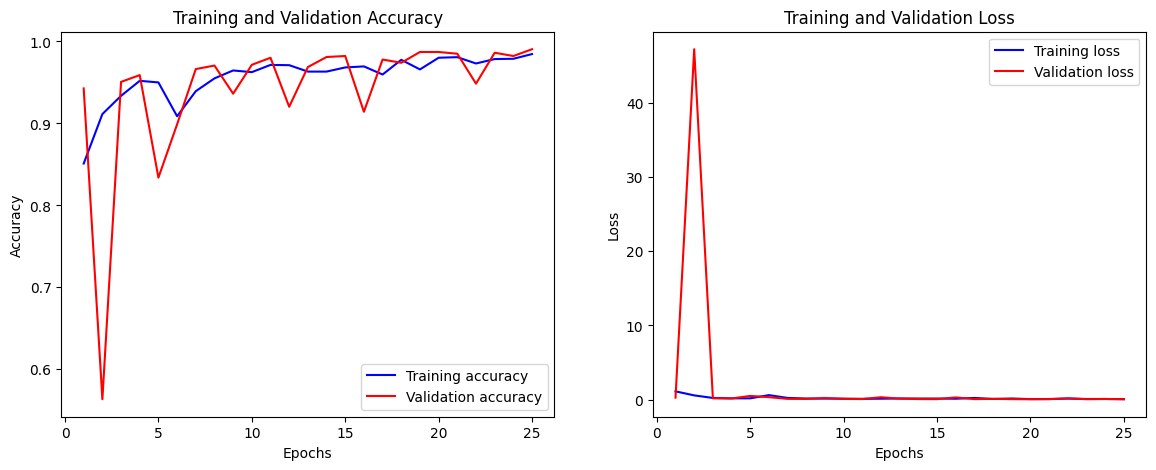

In [ ]:
# Plot the training history
plot_training_history(history)

In [ ]:
model.evaluate(test, verbose=1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.9861 - loss: 0.0671


[0.05276954919099808, 0.9857470989227295]

In [ ]:
model.save('x-ray_cnn_model-v2.h5')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

# model = keras.models.load_model('x-ray_cnn_model-v2.h5')
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

y_test = test_set.label # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))


68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step
              precision    recall  f1-score   support

      normal       0.97      0.99      0.98       695
   pneumonia       1.00      1.00      1.00       776
         tbc       0.99      0.97      0.98       704

    accuracy                           0.99      2175
   macro avg       0.99      0.99      0.99      2175
weighted avg       0.99      0.99      0.99      2175

Accuracy of the Model: 98.6%


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('/content/x-ray_cnn_model-v2.h5')
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Define class labels
class_labels = ['normal', 'pneumonia', 'tbc']

def predict_image(img_path):
    """
    Predict the class of an input image using the trained model.

    Args:
        img_path (str): Path to the input image.

    Returns:
        dict: Predicted class with probability scores for each class.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(244, 244))  # Resize image to model's input size
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Preprocess as in training

    # Perform prediction
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]  # Get class with highest probability
    predicted_probs = {class_labels[i]: float(predictions[0][i]) for i in range(len(class_labels))}

    return {
        "Predicted Class": predicted_class,
        "Probability Scores": predicted_probs
    }

# Test the function
img_path = '/content/pneumonia+efusi-pleura.jpg'
result = predict_image(img_path)

print("Predicted Class:", result["Predicted Class"])
print("Probability Scores:", result["Probability Scores"])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
Predicted Class: tbc
Probability Scores: {'normal': 7.62767854212143e-07, 'pneumonia': 1.6865635624196962e-11, 'tbc': 0.9999992847442627}


### VGG

In [ ]:
from keras.applications import VGG16
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential

# Load the pre-trained VGG16 model without the top classification layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the VGG16 base layers (these won't be trained)
vgg_base.trainable = False

# Build the Sequential model
model = Sequential()

# Add the pre-trained VGG16 base model | extract features only
model.add(vgg_base)

# Add a pooling layer to reduce the output from the VGG model (either Flatten or GlobalAveragePooling)
model.add(GlobalAveragePooling2D()) ## GlobalAveragePooling2D = CNN  |  Flatten

# Add Dense layers on top for the new classification task
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=64, activation='relu'))

# Output layer for 3 classes (adjust the number based on your dataset)
model.add(Dense(units=3, activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=train,
    epochs=100,
    validation_data=val,
    class_weight=class_weights_dict,
    callbacks = callbacks
)

Epoch 1/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6794 - loss: 0.6751
Epoch 1: val_loss did not improve from 0.04480
272/272 ━━━━━━━━━━━━━━━━━━━━ 151s 483ms/step - accuracy: 0.6800 - loss: 0.6739 - val_accuracy: 0.9317 - val_loss: 0.1851 - learning_rate: 0.0010
Epoch 2/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9666 - loss: 0.0957
Epoch 2: val_loss did not improve from 0.04480
272/272 ━━━━━━━━━━━━━━━━━━━━ 90s 325ms/step - accuracy: 0.9666 - loss: 0.0956 - val_accuracy: 0.9838 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 3/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9812 - loss: 0.0557
Epoch 3: val_loss improved from 0.04480 to 0.03779, saving model to checkpoint-combined_model.keras
272/272 ━━━━━━━━━━━━━━━━━━━━ 159s 387ms/step - accuracy: 0.9812 - loss: 0.0557 - val_accuracy: 0.9884 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 4/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9838 - loss: 0.0440
Epoch 4: val_los

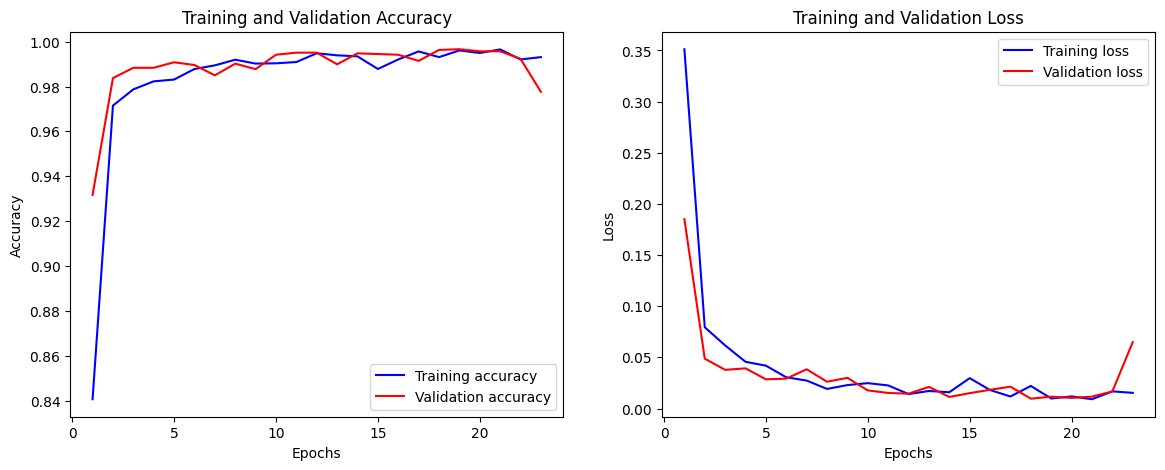

In [ ]:
# Plot the training history
plot_training_history(history)

In [ ]:
model.evaluate(test, verbose=1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 246ms/step - accuracy: 0.9939 - loss: 0.0124


[0.010912599973380566, 0.9954022765159607]

In [ ]:
model.save('x-ray_vgg_model.h5')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

y_test = test_set.label # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))


68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       695
   pneumonia       1.00      1.00      1.00       776
         tbc       0.99      0.99      0.99       704

    accuracy                           1.00      2175
   macro avg       1.00      1.00      1.00      2175
weighted avg       1.00      1.00      1.00      2175

Accuracy of the Model: 99.5%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Constants
IMAGE_SIZE = 244  # Same as used during training
MODEL_PATH = '/content/x-ray_vgg_model.h5'  # Replace with the actual path to the trained model
CLASS_NAMES = ['normal', 'pneumonia', 'tbc']  # Class labels in the same order as the model was trained

# Load the trained model
model = load_model(MODEL_PATH)

# Preprocessing function for inference
def preprocess_image(image_path):
    """
    Preprocess a single image for prediction.
    Args:
        image_path (str): Path to the image file.
    Returns:
        numpy.ndarray: Preprocessed image ready for prediction.
    """
    # Load and resize the image
    img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = img_to_array(img)  # Convert image to array
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Use the same preprocessing function
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Prediction function
def predict_image(image_path):
    """
    Predict the class of an image and provide confidence scores for all classes.
    Args:
        image_path (str): Path to the image file.
    Returns:
        tuple: Predicted class label and a dictionary of confidence scores for all classes.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Perform prediction
    predictions = model.predict(preprocessed_image)[0]  # Extract the single prediction from the batch

    # Get the predicted class index and label
    predicted_class_idx = np.argmax(predictions)
    predicted_class_label = CLASS_NAMES[predicted_class_idx]

    # Create a dictionary of class labels and their confidence scores
    confidence_scores = {CLASS_NAMES[i]: predictions[i] for i in range(len(CLASS_NAMES))}

    return predicted_class_label, confidence_scores

# Example usage
image_path = '/content/chest_xray/test/PNEUMONIA/person139_bacteria_665.jpeg'  # Replace with the actual path to an image
predicted_label, confidence_scores = predict_image(image_path)

# Display results
print(f"Predicted label: {predicted_label}")
print("Confidence scores for all classes:")
for class_name, score in confidence_scores.items():
    print(f"{class_name}: {score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
Predicted label: pneumonia
Confidence scores for all classes:
normal: 0.0000
pneumonia: 1.0000
tbc: 0.0000


### MobileNetV2

In [ ]:
from keras.applications import MobileNetV2
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D, Input
from keras.models import Sequential

base_model = MobileNetV2(include_top=False, input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

for layer in base_model.layers[:-4]:
  layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

<ipython-input-17-0301b6b6ac2f>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 3, 3, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          25,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,182,539 (31.21 MB)

 Trainable params: 6,337,355 (24.18 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=train,
    epochs=100,
    validation_data=val,
    class_weight=class_weights_dict,
    callbacks = callbacks
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8835 - loss: 0.7179
Epoch 1: val_loss improved from inf to 0.02275, saving model to checkpoint-combined_model.keras
272/272 ━━━━━━━━━━━━━━━━━━━━ 111s 349ms/step - accuracy: 0.8837 - loss: 0.7164 - val_accuracy: 0.9951 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 2/100
271/272 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9880 - loss: 0.1096
Epoch 2: val_loss did not improve from 0.02275
272/272 ━━━━━━━━━━━━━━━━━━━━ 77s 280ms/step - accuracy: 0.9880 - loss: 0.1094 - val_accuracy: 0.9776 - val_loss: 0.2598 - learning_rate: 0.0010
Epoch 3/100
271/272 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9905 - loss: 0.0446
Epoch 3: val_loss did not improve from 0.02275
272/272 ━━━━━━━━━━━━━━━━━━━━ 82s 280ms/step - accuracy: 0.9905 - loss: 0.0446 - val_accuracy: 0.9951 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 4/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9922 - loss: 0.0373
Epoch 4: val_loss did not improve

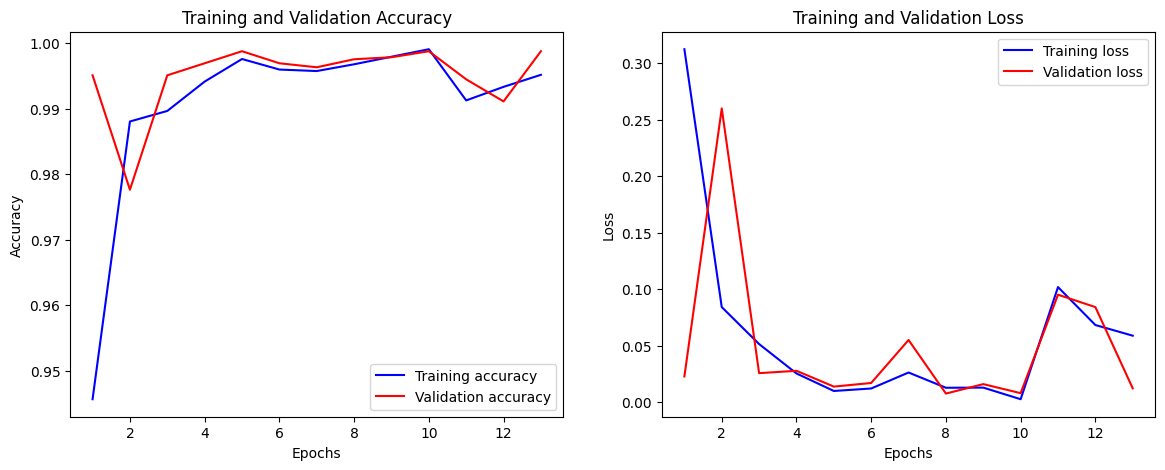

In [ ]:
# Plot the training history
plot_training_history(history)

In [ ]:
model.evaluate(test, verbose=1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9979 - loss: 0.0080


[0.009883403778076172, 0.996781587600708]

In [ ]:
model.save('x-ray_mobilnetv2_model-v2.h5')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

y_test = test_set.label # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))


68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step
              precision    recall  f1-score   support

      normal       1.00      0.99      1.00       695
   pneumonia       0.99      1.00      1.00       776
         tbc       1.00      1.00      1.00       704

    accuracy                           1.00      2175
   macro avg       1.00      1.00      1.00      2175
weighted avg       1.00      1.00      1.00      2175

Accuracy of the Model: 99.7%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Constants
IMAGE_SIZE = 224  # Same as used during training
MODEL_PATH = '/content/x-ray_mobilnetv2_model-v2.h5'  # Replace with the actual path to the trained model
CLASS_NAMES = ['normal', 'pneumonia', 'tbc']  # Class labels in the same order as the model was trained

# Load the trained model
model = load_model(MODEL_PATH)

# Preprocessing function for inference
def preprocess_image(image_path):
    """
    Preprocess a single image for prediction.
    Args:
        image_path (str): Path to the image file.
    Returns:
        numpy.ndarray: Preprocessed image ready for prediction.
    """
    # Load and resize the image
    img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = img_to_array(img)  # Convert image to array
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Use the same preprocessing function
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Prediction function
def predict_image(image_path):
    """
    Predict the class of an image and provide confidence scores for all classes.
    Args:
        image_path (str): Path to the image file.
    Returns:
        tuple: Predicted class label and a dictionary of confidence scores for all classes.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Perform prediction
    predictions = model.predict(preprocessed_image)[0]  # Extract the single prediction from the batch

    # Get the predicted class index and label
    predicted_class_idx = np.argmax(predictions)
    predicted_class_label = CLASS_NAMES[predicted_class_idx]

    # Create a dictionary of class labels and their confidence scores
    confidence_scores = {CLASS_NAMES[i]: predictions[i] for i in range(len(CLASS_NAMES))}

    return predicted_class_label, confidence_scores

# Example usage
image_path = '/content/pneumonia+efusi-pleura.jpg'  # Replace with the actual path to an image
predicted_label, confidence_scores = predict_image(image_path)

# Display results
print(f"Predicted label: {predicted_label}")
print("Confidence scores for all classes:")
for class_name, score in confidence_scores.items():
    print(f"{class_name}: {score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: tbc
Confidence scores for all classes:
normal: 0.0010
pneumonia: 0.0615
tbc: 0.9374
